In [1]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb import Settings

from tinymagic.nlp import helpers as nlp_helper

import umap
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

***
### Load Chroma Collection

In [2]:
embedding_fun = SentenceTransformerEmbeddingFunction(model_name = 'all-MiniLM-L6-v2')
client = chromadb.PersistentClient(path='./LLMs')
client.list_collections()

[Collection(name=sma_smart_home)]

In [3]:
chroma_collection = client.get_collection('sma_smart_home', 
                                          embedding_function=embedding_fun)

print(chroma_collection.count())

153


***
### Get embeddings and project them to 2D, plot

In [4]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

umap_transformer = umap.UMAP(n_components=2,
                             random_state=42,
                             transform_seed=42,
                             n_jobs=1).fit(embeddings)

In [5]:
def get_2d_projections(emb, umap_transform):
    umap_embeddings = np.empty((len(emb),2))
    print(umap_embeddings.shape)
    for i, embdi in enumerate(tqdm(emb)):
        umap_embeddings[i] = umap_transform.transform([embdi])
    return umap_embeddings

In [6]:
projected_embeddings = get_2d_projections(embeddings, umap_transformer)

(153, 2)


  0%|          | 0/153 [00:00<?, ?it/s]

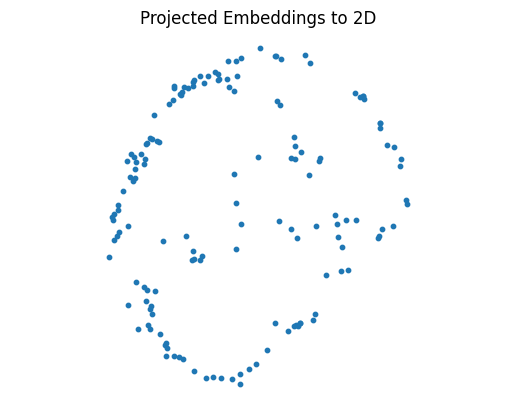

In [7]:
plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings to 2D')
plt.axis('off');

***
### Query collection and plot 

(1, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

(5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

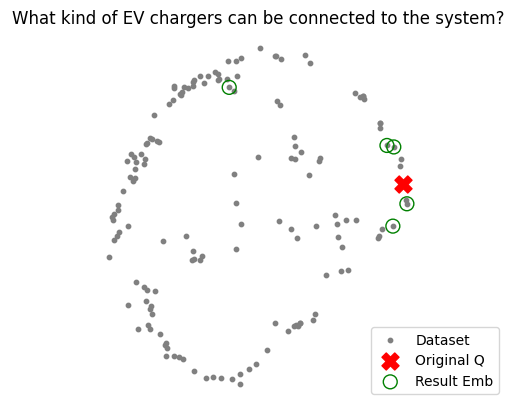

In [8]:
query3 = "What kind of EV chargers can be connected to the system?" 
results = nlp_helper.query_chroma_collection(query3, chroma_collection, 5)

query_embedding = embedding_fun([query3])[0]
resulting_embeddings = results['embeddings'][0]

projected_q_emb = get_2d_projections([query_embedding], umap_transformer)
projected_resulting_emb = get_2d_projections(resulting_embeddings, umap_transformer)

# Plot query and retrieved documents
plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10, color='gray', label='Dataset')
plt.scatter(projected_q_emb[:, 0], projected_q_emb[:, 1], s=150, marker='X', color='r', label='Original Q')
plt.scatter(projected_resulting_emb[:, 0], projected_resulting_emb[:, 1], s=100, facecolors='none', edgecolors='g', label='Result Emb')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query3}', fontsize=12)
plt.legend(loc='lower right')
plt.axis('off');

***
### Query expansion
use LLM to augment and enhance results: 
- **Query expansion with generated answers**
- use query to generate a suggested answer to the question (with an LLM = ask to hallucinate?)
- join query with suggested answer => query ChromaDB

In [10]:
import openai
from openai import OpenAI

openai_client = OpenAI(api_key=key1)

In [11]:
def suggest_new_answer(query, model = "gpt-3.5-turbo"):
    msg = [
        {"role": "system",
         "content":"You are a helpful solar systems engineer. Your client asks you questions about a certain product from the SMA catalogue."
         "Suggest an answer to the given question."
        },
        {"role": "user", 
         "content": query
        }
    ]
    
    response = openai_client.chat.completions.create(messages=msg, model=model)
    return response.choices[0].message.content 

In [28]:
query3 = "Is it possible to connect a hybrid inverter and an EV charger to the Home Manager?"
# query3 = "What kindl of EV chargers can be connected to the system?" 
suggested_answer = suggest_new_answer(query3)

joined = f"{query3} {suggested_answer}"

print(nlp_helper.wrap_text(joined))

Is it possible to connect a hybrid inverter and
an EV charger to the Home Manager? Yes, it is
possible to connect a hybrid inverter and an EV
charger to the Home Manager. The Home Manager is
designed to integrate and manage various devices
in a home energy system, including the hybrid
inverter and the EV charger. By connecting them
to the Home Manager, you can monitor and control
their operation, optimize energy usage, and even
manage their charging schedules based on your
energy needs and preferences.


In [29]:
results = nlp_helper.query_chroma_collection(query3, chroma_collection, 7)
resulting_docs = results['documents'][0]
print(nlp_helper.wrap_chroma_results(resulting_docs))

sma energy system home with hybrid inverter for
high - voltage batteries sma energy system home
sunny tripower smart energy sunny tripower smart
energy with sunny home manager pv inverter [UNK]
[UNK] sunny home manager - [UNK] sma energy meter
[UNK] - sma radio - controlled sockets - •
compatible intelligent loads ( e. g. ev charger )
- • sunny tripower 5. 0 / 6. 0 / 8. 0 / 10. 0
smart [UNK] [UNK] approved high - voltage battery
[UNK] [UNK]

available to achieve the charging goal, the
optionally available home storage is first
discharged for charging the electric vehicle
before the grid - supplied power finally ensures
the readiness for de - parture. after sufficient
charging for the target range, the ev charger
automatically switches to charging with pv
surplus. multi - evc operation mode multi - evc
operation is supported from firmware version 1.
02. # #. r and allows the connection of a maximum
of 3 sma ev chargers. mixed systems with single -
phase charging stations ( evc7. 4 - 1ac

In [30]:
query_embedding = embedding_fun([query3])[0]
suggested_ans_embedding = embedding_fun([joined])[0]
resulting_embeddings = results['embeddings'][0]

projected_q_emb = get_2d_projections([query_embedding], umap_transformer)
projected_suggestion = get_2d_projections([suggested_ans_embedding], umap_transformer)
projected_resulting_emb = get_2d_projections(resulting_embeddings, umap_transformer)

(1, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

(1, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

(7, 2)


  0%|          | 0/7 [00:00<?, ?it/s]

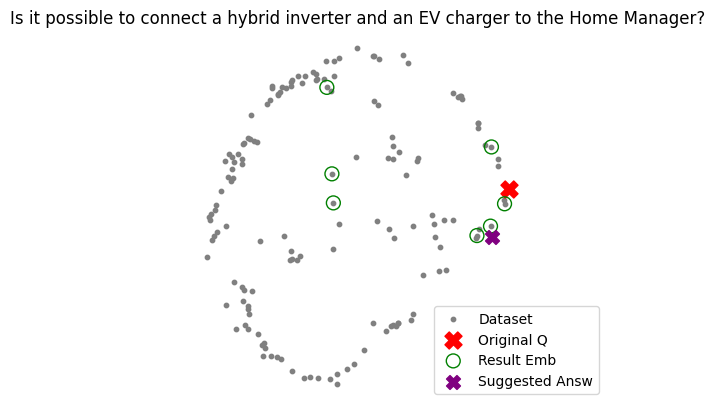

In [77]:
# Plot query and retrieved documents
plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10, color='gray',label='Dataset') # dataset
plt.scatter(projected_q_emb[:, 0], projected_q_emb[:, 1], s=150, marker='X', color='r', label='Original Q')
plt.scatter(projected_resulting_emb[:, 0], projected_resulting_emb[:, 1], s=100, facecolors='none', edgecolors='g', label='Result Emb')
plt.scatter(projected_suggestion[:, 0], projected_suggestion[:, 1], s=100, marker='X', color='purple', label='Suggested Answ')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query3}', fontsize=12)
plt.legend(loc='lower right')
plt.axis('off');

In [32]:
# blue circle: new query with hypothetical answer
# moves query elsewhere in space, hopefully producing better results

- **Query expansion with multiple queries**
- use the LLM to generate additional queries
- retrieve results for original and generated queries
- send all responses to LLM

In [39]:
def generate_new_queries(query, model = "gpt-3.5-turbo"):
    msg = [
        {"role": "system",
         "content":"You are a helpful solar systems engineer. Your client asks you questions about a certain product from the SMA catalogue."
         "Suggest up to five additional questions, that are related to the given question. "
         "Only reply with the additional questions, each one on a new line."
         "Do not number the questions!"
        },
        {"role": "user", 
         "content": query
        }
    ]
    
    response = openai_client.chat.completions.create(messages=msg, model=model)
    content = response.choices[0].message.content 
    return content.split("\n")

In [40]:
query3 = "Is it possible to connect a hybrid inverter and an EV charger to the Home Manager?"
new_queries = generate_new_queries(query3)

for query in new_queries:
    print(query)

What is the maximum power rating of the hybrid inverter that can be connected to the Home Manager?
Can the Home Manager monitor the charging status of the EV connected to the EV charger?
What communication protocols are supported by the Home Manager for connecting the hybrid inverter and EV charger?
Does the Home Manager provide real-time data on the energy usage and charging status of the EV?
Are there any additional accessories or hardware required to connect the hybrid inverter and EV charger to the Home Manager?


In [41]:
all_queries = [query3] + new_queries
results = nlp_helper.query_chroma_collection(all_queries, chroma_collection, 5)

resulting_docs = results['documents']

In [49]:
len(resulting_docs), len(resulting_docs[0])

(6, 5)

In [50]:
unique_docs = set()
for docs in resulting_docs:
    for doc in docs:
        unique_docs.add(doc)
len(unique_docs)

15

In [63]:
query_embedding = embedding_fun([query3])
new_query_embeddings = embedding_fun(new_queries)

projected_q_emb = get_2d_projections(query_embedding, umap_transformer)
projected_new_queries = get_2d_projections(new_query_embeddings, umap_transformer)

(1, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

(5, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

In [64]:
# flatten results
resulting_embeddings = results['embeddings']
resulting_embeddings = [answer for question in resulting_embeddings for answer in question]
projected_res_embeddings = get_2d_projections(resulting_embeddings, umap_transformer)

(30, 2)


  0%|          | 0/30 [00:00<?, ?it/s]

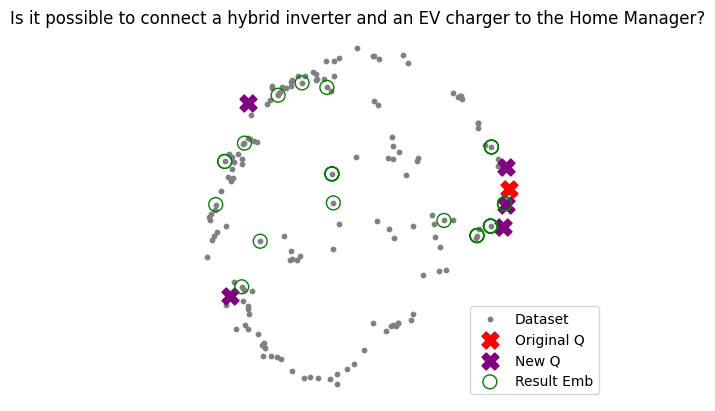

In [75]:
# Plot query and retrieved documents
plt.figure()
plt.scatter(projected_embeddings[:, 0], projected_embeddings[:, 1], s=10, color='gray', label='Dataset') # dataset
plt.scatter(projected_q_emb[:, 0], projected_q_emb[:, 1], s=150, marker='X', color='r', label='Original Q')
plt.scatter(projected_new_queries[:, 0], projected_new_queries[:, 1], s=150, marker='X', color='purple', label='New Q' )
plt.scatter(projected_res_embeddings[:, 0], projected_res_embeddings[:, 1], s=100, facecolors='none', edgecolors='green', label='Result Emb')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query3}', fontsize=12)
plt.legend(loc='lower right')
plt.axis('off');

***
### Cross-encoder re-ranking
 score relevancy of retrieved results for the sent query: 
1. retrieve results from ChromaDB
2. pass results and query to a re-ranking model
3. select top score results

In [10]:
chromadb.__version__

'0.3.29'

In [6]:
client.list_collections()

[Collection(name=sma_smart_home)]